# Adaptive Learning with NV Centers - Data Analysis

## Import Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import qinfer as qi
import models as m
from adaptive import *
from nvdata import *
import scipy.stats as st
import scipy.io as sio
import pandas as pd
from collections import OrderedDict
import textwrap

In [2]:
# Whether to overwrite figures by default while exporting
overwrite = True
# Markers used in line plots
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
marker_list = ['o','v','^','<','>','1','2','3','4','s','p','*','h','H','+']
hatch_list = [None, None, None, None, '/', "\\", r'*', 'o']

def make_letter(val,ypos=0.75,axis=None):
    if axis is not None:
        plt.sca(axis)
    plt.gca().text(0.005, ypos, val,
        verticalalignment='bottom', horizontalalignment='left',
        transform=plt.gca().transAxes,
        fontsize=10
    )

### Import Data

In [3]:
rabi_data = sio.loadmat('../data/rabi.mat')['avgData'] * 200 * 50000
rabi_p = (rabi_data[2,:] - rabi_data[1,:]) / (rabi_data[0,:] - rabi_data[1,:])
rabi_p_stds = est_std(rabi_p, rabi_data[0,:], rabi_data[1,:])
rabi_x = np.linspace(0,0.5,rabi_p.size)

ramsey_data = sio.loadmat('../data/ramsey.mat')['avgData'] * 200 * 50000
ramsey_p = (ramsey_data[2,:] - ramsey_data[1,:]) / (ramsey_data[0,:] - ramsey_data[1,:])
ramsey_p_stds = est_std(rabi_p, ramsey_data[0,:], ramsey_data[1,:])
ramsey_x = np.linspace(0, 2, ramsey_p.size)

In [4]:
transfer_function = HeuristicData('../data/transfer_function_new.pkl')
bernoulli_risk = HeuristicData('../data/bernoulli_risk_final.pkl')
full_risk = HeuristicData('../data/full_bayes_risk.pkl')
linear = HeuristicData('../data/alternating_linear_final.pkl')
linear_full = HeuristicData('../data/alternating_linear_ultimate.pkl')
classic_linear = HeuristicData('../data/classic_linear_final.pkl')
power_curve = HeuristicData('../data/power_curve.pkl')
predetermined_tight_prior = HeuristicData('../data/predetermined_with_tight_prior.pkl')
alternating_linear_tight_prior = HeuristicData('../data/alternating_linear_tight_prior.pkl')
full_bayes_tight_prior = HeuristicData('../data/full_bayes_risk_with_tight_prior.pkl')
full_bayes_tight_prior_mag = HeuristicData('../data/full_bayes_risk_with_tight_prior_magnetometry.pkl')
full_bayes_mag = HeuristicData('../data/full_bayes_risk_mag.pkl')

Imported existing Panel with 7 DataFrames from ../data/transfer_function_new.pkl
Imported existing Panel with 100 DataFrames from ../data/bernoulli_risk_final.pkl
Imported existing Panel with 100 DataFrames from ../data/full_bayes_risk.pkl
Imported existing Panel with 139 DataFrames from ../data/alternating_linear_final.pkl
Imported existing Panel with 100 DataFrames from ../data/alternating_linear_ultimate.pkl
Imported existing Panel with 100 DataFrames from ../data/classic_linear_final.pkl
Imported existing Panel with 15 DataFrames from ../data/power_curve.pkl
Imported existing Panel with 100 DataFrames from ../data/predetermined_with_tight_prior.pkl
Imported existing Panel with 100 DataFrames from ../data/alternating_linear_tight_prior.pkl
Imported existing Panel with 100 DataFrames from ../data/full_bayes_risk_with_tight_prior.pkl
Imported existing Panel with 100 DataFrames from ../data/full_bayes_risk_with_tight_prior_magnetometry.pkl
Imported existing Panel with 100 DataFrames fr

Use `OrderedDict` so that things predictably match up with the color, hatching, etc lists defined above.

In [5]:
panels = OrderedDict([
    ('Alternating Linear', linear_full),
    ('Uniformly Weighted Risk', full_risk),
    ('Magnetometry Weighted Risk', full_bayes_mag),
    #('Classic Linear', classic_linear)
])

In [6]:
panels_tight = OrderedDict([
    ('Alternating Linear', alternating_linear_tight_prior),
    ('Uniformly Weighted Risk', full_bayes_tight_prior),
    ('Magnetometry Weighted Risk', full_bayes_tight_prior_mag),
    ('Ramsey Sweeps', predetermined_tight_prior)
])

### Plotting Learning Rates

In [75]:
def plot_panel_learning(panels, idx_param, param_name=None, normalized=False):
    x_column='cum_eff_num_bits'
    markers = iter(marker_list)
    hatches = iter(hatch_list)
    colors = iter(color_list)
    all_x, all_y = {}, {}
    max_y = 0
    for name, panel in panels.iteritems():
        print name
        all_x[name], all_y[name] = extract_panel_data(
            panel, 'smc_cov', 
            idxs=np.s_[idx_param,idx_param], 
            x_column=x_column
        )
        max_y = max(max_y, np.percentile(all_y[name][:,0], 50))
    if not normalized:
        max_y = 1
        
    for name, panel in panels.iteritems():
        x_vals, y_vals = all_x[name], all_y[name] / max_y
        lower, upper, mid = np.percentile(y_vals, [90,10,50], axis=0)
        #plt.semilogy(x_vals, np.mean(y_vals, axis=0), label=name)
        color = next(colors)
        line = plt.semilogy(x_vals+1, mid, '--', markevery=20, marker=next(markers), label=name, color=color)
        plt.fill_between(x_vals+1, lower, upper, alpha=0.2, hatch=next(hatches), edgecolor=color)

    plt.grid()
    if param_name is None:
        model = m.RabiRamseyModel()
        param_name = model.modelparam_names[idx_param]
    if normalized:
        plt.ylabel(r'${}$'.format(param_name))
    else:
        plt.ylabel(r'${}$ Posterior Variance (MHz$^2$)'.format(param_name))
    plt.xlabel('Cumulative ESM')
    plt.legend()
    
def plot_panel_eps_histogram(panels, ax_rabi=None, ax_ramsey=None, linear_thresh=None):
    if ax_rabi is None and ax_ramsey is None:
        gs = gridspec.GridSpec(1,2)
        ax_rabi = plt.subplot(gs[0])
        ax_ramsey = plt.subplot(gs[1],sharey=ax_rabi)
        
    hatches = iter(hatch_list)
    colors = iter(color_list)
    for name, panel in panels.iteritems():
        _, eps_array = extract_panel_data(panel, 'expparam', skip_first=True, skip_last=True, idxs=np.s_[0])
        hatch, color = next(hatches), next(colors)
        hatch = 3 * hatch if hatch is not None else None
        if ax_rabi is not None:
            plt.sca(ax_rabi)
            ts = eps_array['t'][eps_array['emode']==m.RabiRamseyModel.RABI]
            plt.hist(ts, bins=np.linspace(0,1,101)+0.0025, alpha=0.5, linewidth=0, label=name, normed=False, weights=np.ones(ts.size)/panel.n_dataframes, hatch=hatch, edgecolor=color)
            plt.xlabel(r'$t_p$ ($\mu$s)')
        
        if ax_ramsey is not None:
            plt.sca(ax_ramsey)
            ts = eps_array['tau'][eps_array['emode']==m.RabiRamseyModel.RAMSEY]
            plt.hist(ts, bins=np.linspace(0,2,101)+0.0025, alpha=0.5, linewidth=0, label=name, normed=False, weights=np.ones(ts.size)/panel.n_dataframes, hatch=hatch, edgecolor=color)
            plt.xlabel(r'$t_w$ ($\mu$s)')
            
    if linear_thresh is not None:
        ticks = range(1,linear_thresh+1) + list(np.linspace(0,100,11)[np.linspace(0,100,11)>linear_thresh+1])
        labeled_ticks = [1,5,10,50]
        for ax in [ax_rabi, ax_ramsey]:
            if ax is not None:
                ax.set_yscale('symlog', linthreshy=linear_thresh)
                ax.set_yticks(ticks)
                ax.yaxis.set_major_formatter(
                    ticker.FuncFormatter(lambda x,_:'{}'.format(int(x)) if x in labeled_ticks else '')
                )
                ax.set_ylim([0,60])
            
def plot_panels(panels):
    gs1 = gridspec.GridSpec(1,1, bottom=0.5)
    ax_learning = plt.subplot(gs1[0])
    plt.sca(ax_learning)
    plot_panel_learning(panels, m.RabiRamseyModel.IDX_ZEEMAN)
    plt.legend(loc=1)
    make_letter('(a)', ypos=0.85)

    plt.xlabel('Cumulative ESM')
    plt.ylabel(r'$\omega_e$ posterior variance (MHz$^2$)')

    gs2 = gridspec.GridSpec(1,2, top=0.3)

    ax_rabi_hist = plt.subplot(gs2[0])
    ax_ramsey_hist = plt.subplot(gs2[1], sharey=ax_rabi_hist)

    plot_panel_eps_histogram(panels, ax_rabi_hist, ax_ramsey_hist, linear_thresh=5)
    ax_rabi_hist.set_ylabel(r'$\langle$# Times Used$\rangle$')
    make_letter('(b) Rabi', ypos=0.83, axis=ax_rabi_hist)
    make_letter('(c) Ramsey', ypos=0.83, axis=ax_ramsey_hist)

    plt.setp(ax_ramsey_hist.get_yticklabels(), visible=False)
    gs1.tight_layout(fig, rect=[None,0.34,None,None], h_pad=0)
    gs2.tight_layout(fig, rect=[None,None,None,0.39], w_pad=0, h_pad=0)

<IPython.core.display.Javascript object>


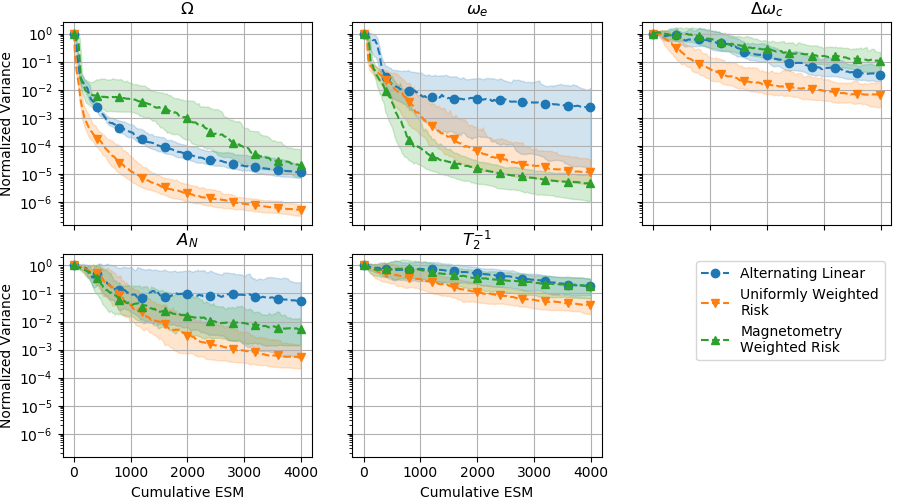

Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Saving ../fig/param-learning-rates.png
Saving ../fig/param-learning-rates.pdf


In [111]:
idxs_to_plot = [0, 1, 2, 3, 4]
n_cols = 3
n_rows = int(np.ceil((len(idxs_to_plot) + 1 ) / n_cols))

fig = plt.figure(figsize=(n_cols * 3, n_rows * 2.5))
gs = gridspec.GridSpec(n_rows, n_cols)

idx = 0
axes = {}
min_y, max_x, min_y, max_y = np.inf, 0, np.inf, 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):
        if idx < len(idxs_to_plot):
            idx_param = idxs_to_plot[idx]
            
            sharey = axes[(idx_row, 0)] if (idx_row, 0) in axes else None
            sharex = axes[(0, idx_col)] if (0, idx_col) in axes else None
            ax = plt.subplot(gs[idx_row, idx_col])
            axes[(idx_row, idx_col)] = ax

            #plt.plot([0,np.random.rand()],[0,np.random.rand()])
            plot_panel_learning(panels, idx_param, normalized=True)
            
            min_x, max_x = min(min_x, ax.get_xlim()[0]), max(max_x, ax.get_xlim()[1])
            min_y, max_y = min(min_y, ax.get_ylim()[0]), max(max_y, ax.get_ylim()[1])
            
            handles, labels = ax.get_legend_handles_labels()
            labels = ['\n'.join(textwrap.wrap(label, 20)) for label in labels]
            ax.get_legend().set_visible(False)
            ax.set_title(ax.get_ylabel())
            
            if idx_row != n_rows - 1:
                ax.set_xticklabels([''] * len(ax.get_xticklabels()))
                ax.set_xlabel('')
            if idx_col != 0:
                ax.set_yticklabels([''] * len(ax.get_yticklabels()))
                ax.set_ylabel('')
            else:
                ax.set_ylabel('Normalized Variance')
        elif idx == len(idxs_to_plot):
            ax = plt.subplot(gs[idx_row, idx_col])
            plt.legend(handles, labels)
            ax.axis('off')
                
        idx += 1
            
for ax in fig.axes:
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])
    
gs.tight_layout(fig, pad=0, h_pad=0, w_pad=0)
export_figure(fig, 'param-learning-rates')

<IPython.core.display.Javascript object>


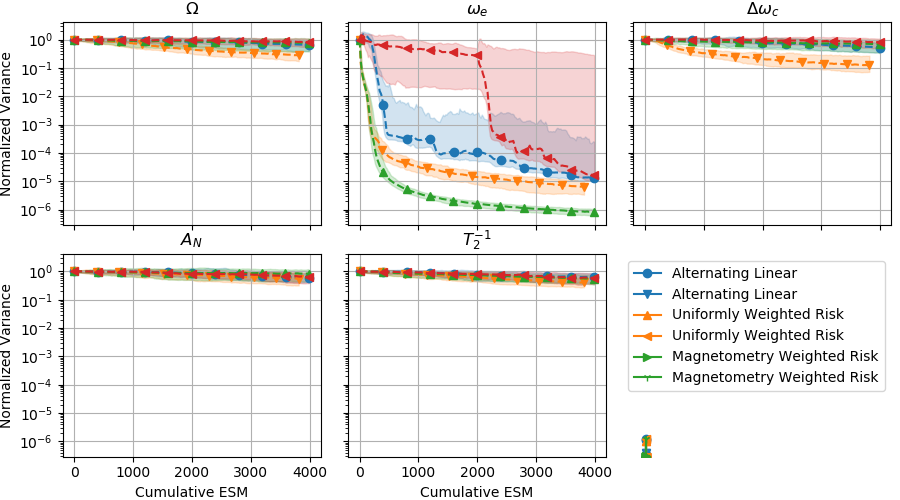

Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Ramsey Sweeps
Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Ramsey Sweeps
Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Ramsey Sweeps
Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Ramsey Sweeps
Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Ramsey Sweeps
Saving ../fig/param-learning-rates-tight.png
Saving ../fig/param-learning-rates-tight.pdf


In [112]:
idxs_to_plot = [0, 1, 2, 3, 4]
n_cols = 3
n_rows = int(np.ceil((len(idxs_to_plot) + 1 ) / n_cols))

fig = plt.figure(figsize=(n_cols * 3, n_rows * 2.5))
gs = gridspec.GridSpec(n_rows, n_cols)

idx = 0
axes = {}
min_y, max_x, min_y, max_y = np.inf, 0, np.inf, 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):
        if idx < len(idxs_to_plot):
            idx_param = idxs_to_plot[idx]
            
            sharey = axes[(idx_row, 0)] if (idx_row, 0) in axes else None
            sharex = axes[(0, idx_col)] if (0, idx_col) in axes else None
            ax = plt.subplot(gs[idx_row, idx_col])
            axes[(idx_row, idx_col)] = ax

            #plt.plot([0,np.random.rand()],[0,np.random.rand()])
            plot_panel_learning(panels_tight, idx_param, normalized=True)
            
            min_x, max_x = min(min_x, ax.get_xlim()[0]), max(max_x, ax.get_xlim()[1])
            min_y, max_y = min(min_y, ax.get_ylim()[0]), max(max_y, ax.get_ylim()[1])
            
            handles, labels = ax.get_legend_handles_labels()
            labels = ['\n'.join(textwrap.wrap(label, 20)) for label in labels]
            ax.get_legend().set_visible(False)
            ax.set_title(ax.get_ylabel())
            
            if idx_row != n_rows - 1:
                ax.set_xticklabels([''] * len(ax.get_xticklabels()))
                ax.set_xlabel('')
            if idx_col != 0:
                ax.set_yticklabels([''] * len(ax.get_yticklabels()))
                ax.set_ylabel('')
            else:
                ax.set_ylabel('Normalized Variance')
        elif idx == len(idxs_to_plot):
            ax = plt.subplot(gs[idx_row, idx_col])
            plt.legend(handles, labels)
            ax.axis('off')
                
        idx += 1
            
for ax in fig.axes:
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])
    
gs.tight_layout(fig, pad=0, h_pad=0, w_pad=0)
export_figure(fig, 'param-learning-rates-tight')

<IPython.core.display.Javascript object>


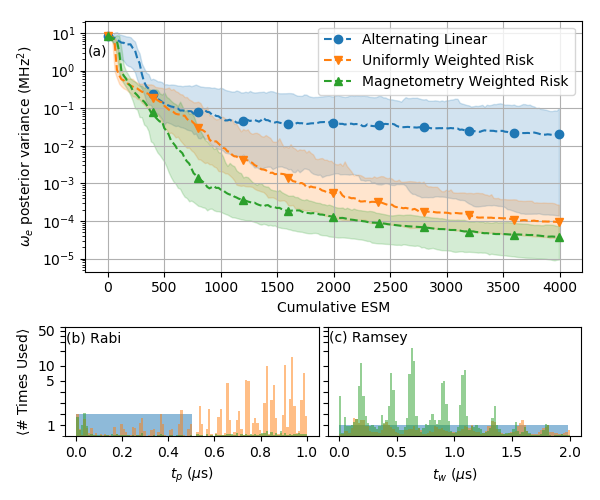

Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk


In [8]:
fig = plt.figure(figsize=(6,5))
plot_panels(panels)

<IPython.core.display.Javascript object>


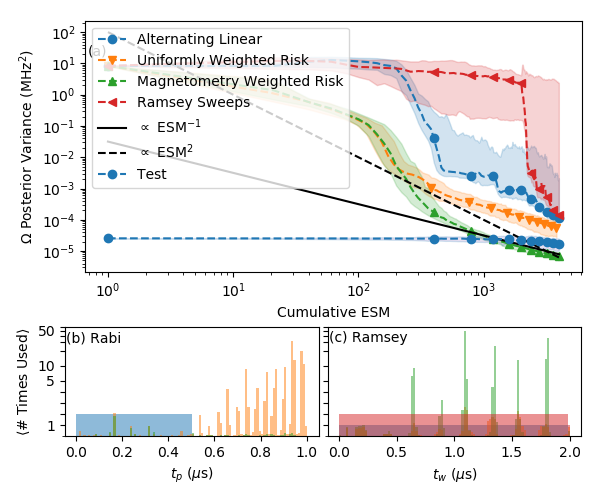

Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Ramsey Sweeps


In [14]:
fig = plt.figure(figsize=(6,5))
plot_panels(panels_tight)

plt.gcf().axes[0].set_xscale('log')
plt.sca(plt.gcf().axes[0])
plt.plot(range(1,4000),(10.**-1.5)*(np.arange(1,4000,dtype=float)**-1),color='k', label='$\propto$ ESM$^{-1}$')

plt.plot(range(1,4000),(10.**2)*(np.arange(1,4000,dtype=float)**-2),color='k', ls='--', label='$\propto$ ESM$^{2}$')

plt.legend()

<IPython.core.display.Javascript object>


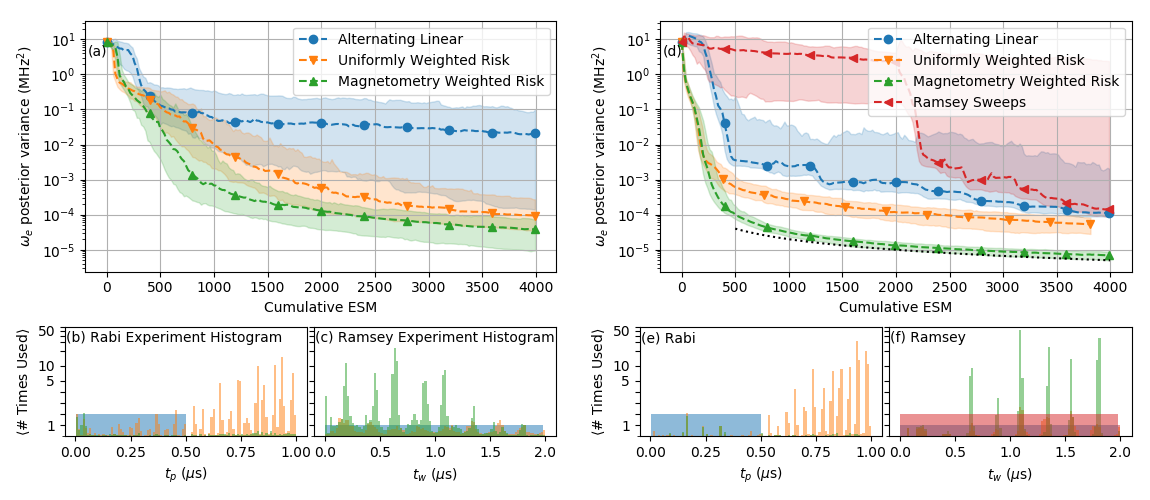

Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Ramsey Sweeps
Overwriting ../fig/heuristic-comparison.png
Overwriting ../fig/heuristic-comparison.pdf


In [184]:
fig = plt.figure(figsize=(11.5,5))

### LEFT

gs1 = gridspec.GridSpec(1,1, bottom=0.5, right=0.45)
ax_learning = plt.subplot(gs1[0])
plt.sca(ax_learning)
plot_panel_learning(panels, m.RabiRamseyModel.IDX_ZEEMAN)
plt.legend(loc=1)
make_letter('(a)', ypos=0.85)

plt.xlabel('Cumulative ESM')
plt.ylabel(r'$\omega_e$ posterior variance (MHz$^2$)')

gs2 = gridspec.GridSpec(1,2, top=0.3, right=0.45)

ax_rabi_hist = plt.subplot(gs2[0])
ax_ramsey_hist = plt.subplot(gs2[1], sharey=ax_rabi_hist)

plot_panel_eps_histogram(panels, ax_rabi_hist, ax_ramsey_hist, linear_thresh=5)
ax_rabi_hist.set_ylabel(r'$\langle$# Times Used$\rangle$')
make_letter('(b) Rabi Experiment Histogram', ypos=0.83, axis=ax_rabi_hist)
make_letter('(c) Ramsey Experiment Histogram', ypos=0.83, axis=ax_ramsey_hist)

plt.setp(ax_ramsey_hist.get_yticklabels(), visible=False)

### RIGHT

gs3 = gridspec.GridSpec(1,1, bottom=0.5, left=0.55)
ax_learning = plt.subplot(gs3[0], sharey=ax_learning)
plt.sca(ax_learning)
plot_panel_learning(panels_tight, m.RabiRamseyModel.IDX_ZEEMAN)
plt.plot(range(500,4000),(10.**-1.7)*(np.arange(500,4000,dtype=float)**-1),color='k',ls=':')
plt.legend(loc=1)
make_letter('(d)', ypos=0.85)

plt.xlabel('Cumulative ESM')
plt.ylabel(r'$\omega_e$ posterior variance (MHz$^2$)')

gs4 = gridspec.GridSpec(1,2, top=0.3, left=0.55)

ax_rabi_hist = plt.subplot(gs4[0])
ax_ramsey_hist = plt.subplot(gs4[1], sharey=ax_rabi_hist)

plot_panel_eps_histogram(panels_tight, ax_rabi_hist, ax_ramsey_hist, linear_thresh=5)
ax_rabi_hist.set_ylabel(r'$\langle$# Times Used$\rangle$')
make_letter('(e) Rabi', ypos=0.83, axis=ax_rabi_hist)
make_letter('(f) Ramsey', ypos=0.83, axis=ax_ramsey_hist)

plt.setp(ax_ramsey_hist.get_yticklabels(), visible=False)

gs1.tight_layout(fig, rect=[0,0.34,0.5,1], h_pad=0)
gs2.tight_layout(fig, rect=[0,0,0.5,0.39], w_pad=0, h_pad=0)
gs3.tight_layout(fig, rect=[0.5,0.34,1,1], h_pad=0)
gs4.tight_layout(fig, rect=[0.5,0,1,0.39], w_pad=0, h_pad=0)

export_figure(fig, 'heuristic-comparison')

### Plotting Posteriors

In [190]:
def plot_panel_posterior(panels, idx_param, param_name=None):
    
    markers = iter(marker_list)
    hatches = iter(hatch_list)
    colors = iter(color_list)

    for name, panel in panels.iteritems():
        means = np.array([df.smc_mean[len(df)-1] for df in panel._df_dict.values()])[:,idx_param]
        stds = np.sqrt(np.array([df.smc_cov[len(df)-1] for df in panel._df_dict.values()])[:,idx_param,idx_param])
        color = next(colors)

        idx = 0
        xs = np.linspace(means[idx] - stds[idx] * 5, means[idx] + 5 * stds[idx], 401)
        ys = st.norm.pdf(xs, loc=means[idx], scale=stds[idx])
        plt.plot(xs, ys, markevery=20, marker=next(markers), label=name, color=color)
        

    if param_name is None:
        model = m.RabiRamseyModel()
        param_name = model.modelparam_names[idx_param]
        
    
    plt.xlabel('${}$ (MHz)'.format(param_name))
    plt.legend()

<IPython.core.display.Javascript object>


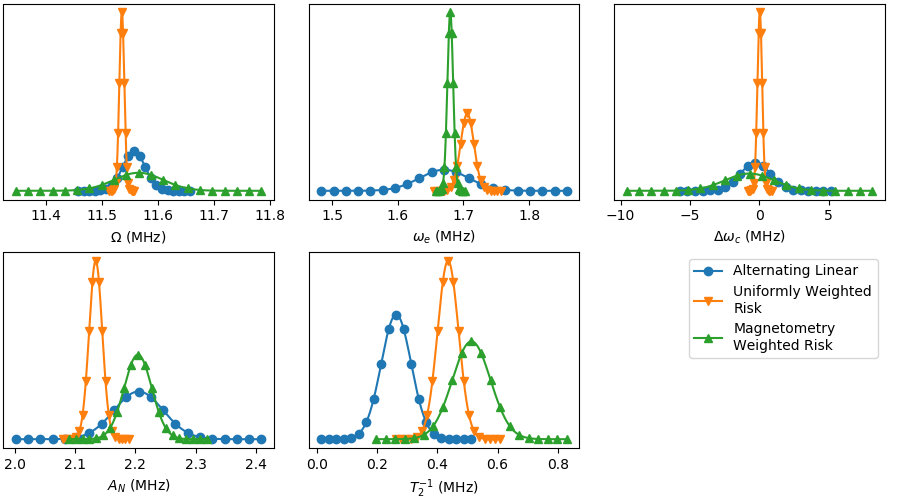

Overwriting ../fig/param-posteriors.png
Overwriting ../fig/param-posteriors.pdf


In [193]:
idxs_to_plot = [0, 1, 2, 3, 4]
n_cols = 3
n_rows = int(np.ceil((len(idxs_to_plot) + 1 ) / n_cols))

fig = plt.figure(figsize=(n_cols * 3, n_rows * 2.5))
gs = gridspec.GridSpec(n_rows, n_cols)

idx = 0
axes = {}
for idx_row in range(n_rows):
    for idx_col in range(n_cols):
        if idx < len(idxs_to_plot):
            idx_param = idxs_to_plot[idx]
            
            sharey = axes[(idx_row, 0)] if (idx_row, 0) in axes else None
            sharex = axes[(0, idx_col)] if (0, idx_col) in axes else None
            ax = plt.subplot(gs[idx_row, idx_col])
            axes[(idx_row, idx_col)] = ax

            #plt.plot([0,np.random.rand()],[0,np.random.rand()])
            plot_panel_posterior(panels, idx_param)
            
            handles, labels = ax.get_legend_handles_labels()
            labels = ['\n'.join(textwrap.wrap(label, 20)) for label in labels]
            ax.get_legend().set_visible(False)
            ax.set_title(ax.get_ylabel())
            ax.get_yaxis().set_ticks([])
            
        elif idx == len(idxs_to_plot):
            ax = plt.subplot(gs[idx_row, idx_col])
            plt.legend(handles, labels)
            ax.axis('off')
                
        idx += 1

gs.tight_layout(fig, pad=0, h_pad=0, w_pad=0)
export_figure(fig, 'param-posteriors')

<IPython.core.display.Javascript object>


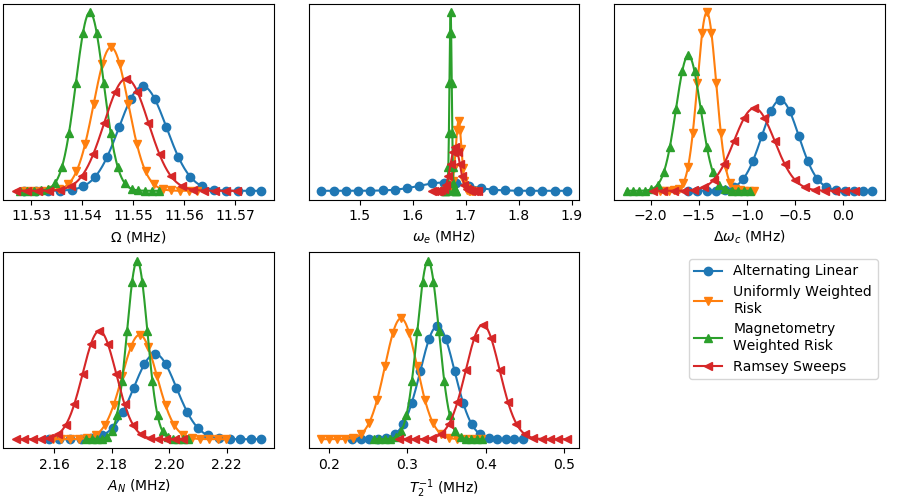

Saving ../fig/param-posteriors-tight.png
Saving ../fig/param-posteriors-tight.pdf


In [192]:
idxs_to_plot = [0, 1, 2, 3, 4]
n_cols = 3
n_rows = int(np.ceil((len(idxs_to_plot) + 1 ) / n_cols))

fig = plt.figure(figsize=(n_cols * 3, n_rows * 2.5))
gs = gridspec.GridSpec(n_rows, n_cols)

idx = 0
axes = {}
for idx_row in range(n_rows):
    for idx_col in range(n_cols):
        if idx < len(idxs_to_plot):
            idx_param = idxs_to_plot[idx]
            
            sharey = axes[(idx_row, 0)] if (idx_row, 0) in axes else None
            sharex = axes[(0, idx_col)] if (0, idx_col) in axes else None
            ax = plt.subplot(gs[idx_row, idx_col])
            axes[(idx_row, idx_col)] = ax

            #plt.plot([0,np.random.rand()],[0,np.random.rand()])
            plot_panel_posterior(panels_tight, idx_param)
            
            handles, labels = ax.get_legend_handles_labels()
            labels = ['\n'.join(textwrap.wrap(label, 20)) for label in labels]
            ax.get_legend().set_visible(False)
            ax.set_title(ax.get_ylabel())
            ax.get_yaxis().set_ticks([])
            
        elif idx == len(idxs_to_plot):
            ax = plt.subplot(gs[idx_row, idx_col])
            plt.legend(handles, labels)
            ax.axis('off')
                
        idx += 1

gs.tight_layout(fig, pad=0, h_pad=0, w_pad=0)
export_figure(fig, 'param-posteriors-tight')

<IPython.core.display.Javascript object>


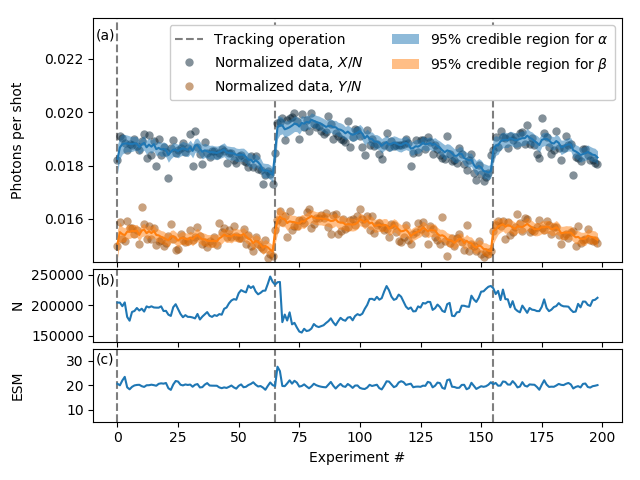

Overwriting ../fig/tracking-example.png
Overwriting ../fig/tracking-example.pdf


In [8]:
fig = plt.figure()
gs = gridspec.GridSpec(3,1,height_ratios=[1,0.3,0.3])

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

df = linear.panel[21]
esm = np.array(list(df.eff_num_bits)[1:-1])
n_meas = np.array(list(df.expparam)[1:-1])['n_meas'].flatten()
bright = np.array(list(df.bright)[1:-1]) / n_meas
dark = np.array(list(df.dark)[1:-1]) / n_meas

means = np.array(list(df.smc_mean)[1:-1])
alpha = means[:,5]
beta = means[:,6]

std_mult = 2
covs = np.array(list(df.smc_cov)[1:-1])
alpha_std = std_mult * np.sqrt(covs[:,5,5])
beta_std = std_mult * np.sqrt(covs[:,6,6])

def plot_tracks():
    track_locs = np.arange(alpha.size+1)[np.diff(np.nan_to_num(np.array(list(df.preceded_by_tracking)),0)) == 1]
    for idx_loc, loc in enumerate(track_locs):
        label = 'Tracking operation' if idx_loc==0 else None
        plt.axvline(loc, color='k', ls='--', zorder=0, alpha=0.5, label=label)

plt.subplot(gs[1])
plt.plot(n_meas)
plot_tracks()
make_letter('(b)')
plt.gca().set_xticklabels([])
plt.ylabel('N')
plt.ylim([140000,260000])
plt.gca().get_yaxis().set_label_coords(-0.13,0.5)
plt.gca().ticklabel_format(axis='y',style='sci')

plt.subplot(gs[2])
plt.plot(esm)
plot_tracks()
make_letter('(c)')
plt.yticks([10,20,30])
plt.ylim([5,35])
plt.ylabel('ESM')
plt.gca().get_yaxis().set_label_coords(-0.13,0.5)
plt.xlabel('Experiment #')

plt.subplot(gs[0])
plt.plot(alpha, color=color_list[0])
plt.plot(bright, 'o', zorder=0, alpha=0.5, markeredgewidth=0, color=lighten_color(color_list[0],1.5), label='Normalized data, $X/N$')
plt.fill_between(np.arange(alpha.size), alpha - alpha_std, alpha + alpha_std, 
                 lw=0, alpha=0.5, color=color_list[0], 
                 label=r'95% credible region for $\alpha$'
            )
plt.plot(beta, color=color_list[1])
plt.plot(dark, 'o', zorder=0, alpha=0.5, markeredgewidth=0, color=lighten_color(color_list[1],1.5), label='Normalized data, $Y/N$')
plt.fill_between(np.arange(alpha.size), 
                 beta - beta_std, beta + beta_std, 
                 lw=0, alpha=0.5, color=color_list[1],
                 label=r'95% credible region for $\beta$'
            )
make_letter('(a)',0.9)

plt.ylabel('Photons per shot')
plt.gca().set_xticklabels([])
plt.gca().get_yaxis().set_label_coords(-0.13,0.5)

plot_tracks()
    
plt.ylim([0.0144, 0.0235])
plt.legend(ncol=2)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1,3,4]
leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=1,ncol=2)
leg.get_frame().set_alpha(1)

gs.tight_layout(fig, h_pad=0)

export_figure(fig, 'tracking-example')

### Power Curve

<IPython.core.display.Javascript object>


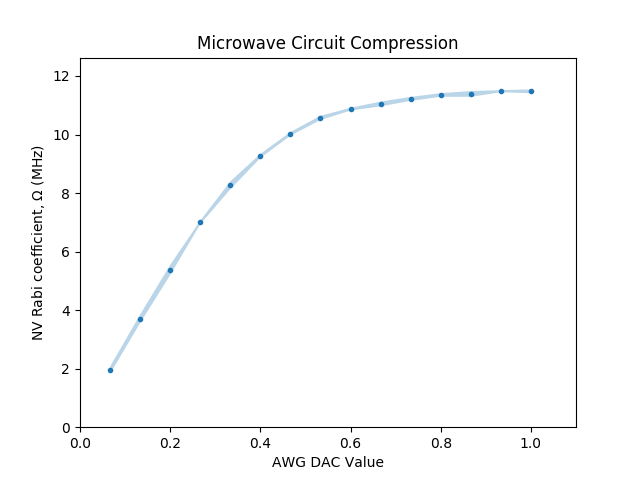

In [25]:
linear_powers = np.empty(power_curve.n_dataframes)
power_curve_ests = np.empty((power_curve.n_dataframes, 5))
power_curve_stds = np.empty((power_curve.n_dataframes, 5))
for idx_df in range(power_curve.n_dataframes):
    df = power_curve.panel[idx_df]
    linear_powers[idx_df] = 10 ** (np.array(list(df.heuristic_value))[-1] / 20)
    power_curve_ests[idx_df, :] = np.array(list(df.smc_mean))[-1,:5]
    power_curve_stds[idx_df, :] = np.sqrt(np.diag(np.array(list(df.smc_cov))[-1,:5,:5]))

plt.figure()
idx_param = 0
plt.plot(linear_powers, power_curve_ests[:,idx_param],'.')
plt.fill_between(
    linear_powers, 
    power_curve_ests[:,idx_param] - 3*power_curve_stds[:,idx_param], 
    power_curve_ests[:,idx_param] + 3*power_curve_stds[:,idx_param],
    alpha=0.3
)
plt.ylim([0, 1.1*np.amax(power_curve_ests[:,idx_param])])
plt.xlim([0, 1.1*np.amax(linear_powers)])

plt.title('Microwave Circuit Compression')
plt.xlabel('AWG DAC Value')
plt.ylabel('NV Rabi coefficient, $\Omega$ (MHz)')

In [161]:
offsets = []
for idx_df in range(transfer_function.n_dataframes):
    df = transfer_function.panel[idx_df]
    offsets.append(df.expparam[1]['wo'])
offsets = np.array(offsets).flatten()
n_offsets = offsets.size

transfer_function_ests = np.empty((n_offsets, 5))
transfer_function_stds = np.empty((n_offsets, 5))
for idx_df in range(transfer_function.n_dataframes):
    df = transfer_function.panel[idx_df]
    transfer_function_ests[idx_df, :] = df.smc_mean[200][:5]
    transfer_function_stds[idx_df, :] = np.sqrt(np.diag(df.smc_cov[200][:5,:5]))

In [86]:
tf_data = np.array([
    [
        list(new_linear.panel[idx_df][label][1:] )
        for idx_df in range(new_linear.n_dataframes)
    ] for label in ['bright', 'dark', 'signal']
]).transpose(1,2,0)

<IPython.core.display.Javascript object>


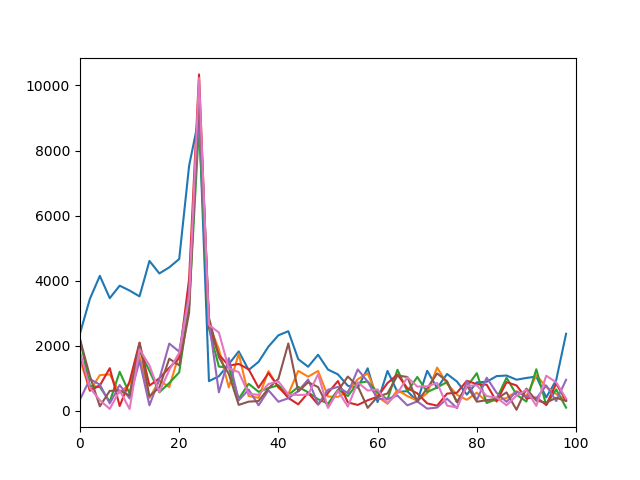

(0, 100)

In [83]:
fig = plt.figure()
for idx in range(7):
    plt.plot(
        np.fft.fftshift(np.fft.fftfreq(tf_data.shape[1]//2, 0.5/100)),
        np.abs(np.fft.fftshift(np.fft.fft(tf_data[idx,::2,2]-np.mean(tf_data[idx,:,2]))))
    )
plt.xlim([0,100])

### Plot some Rabi and Ramsey data

<IPython.core.display.Javascript object>


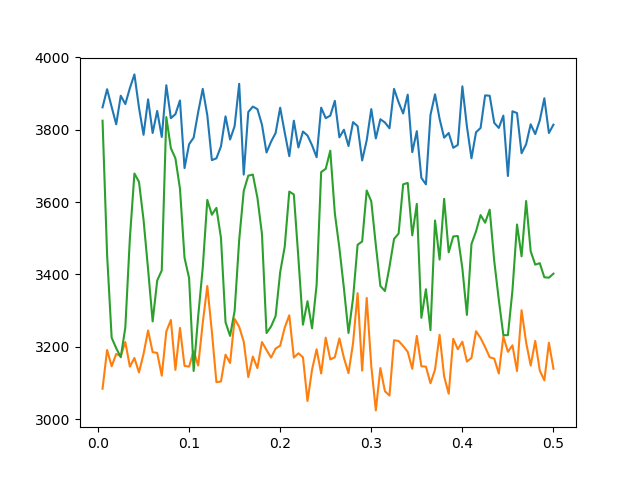

In [162]:
fig = plt.figure()
plt.plot(rabi_x[1:], tf_data[0,::2,0])
plt.plot(rabi_x[1:], tf_data[0,::2,1])
plt.plot(rabi_x[1:], tf_data[0,::2,2])

<IPython.core.display.Javascript object>


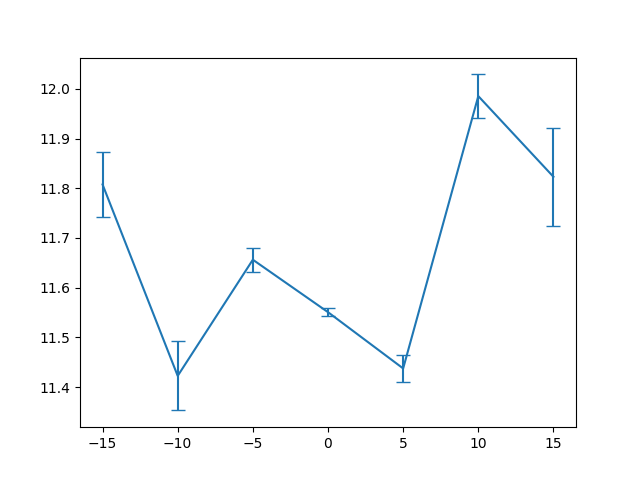

<Container object of 3 artists>

In [163]:
plt.figure()
plt.errorbar(offsets, transfer_function_ests[:,0], yerr=transfer_function_stds[:,0], capsize=5)

<IPython.core.display.Javascript object>


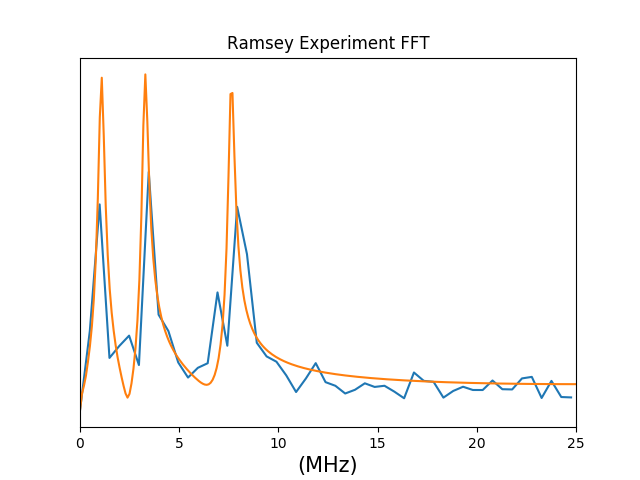

In [49]:
df = linear.panel[10]

fig = plt.figure()

freqs = np.fft.fftshift(np.fft.fftfreq(ramsey_x.size, ramsey_x[1]-ramsey_x[0]))
ramsey_fft = np.fft.fftshift(np.fft.fft(ramsey_p-np.mean(ramsey_p)))
plt.plot(freqs, np.abs(ramsey_fft))

modelparams = list(df.smc_mean)[-1][:5]
freqs, sim_fft = simulate_ramsey_fft(modelparams, max_tau=10,n=501,tp=0.022)
plt.plot(freqs, np.abs(sim_fft))

plt.xlim([0,25])
plt.xlabel(r'(MHz)', size=15)
plt.yticks([])
plt.title('Ramsey Experiment FFT')